In [63]:
import warnings
import os

import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from datetime import datetime
from tqdm import tqdm

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

In [206]:
def parse_datetime(dt):
    time_formats = ["%d/%m/%Y %H:%M:%S %p", "%Y-%m-%d %H:%M:%S", '%Y-%m-%d %H:%M:%S.%f']

    for fmt in time_formats:
        try:
            return datetime.strptime(dt, fmt)
        except ValueError:
            pass
    
    raise ValueError('no valid date format found')

def preprocess(file_path: str ) -> pd.DataFrame:
    "preprocesses the raw dataset into a usable format for data science"
    # Read in dataframe
    for header_row in [0,1,2,3]:
        df_raw = pd.read_excel(file_path, header=header_row)
        if 'PriceUpdatedDate' in df_raw.columns:
            break
    
    # Filter df, convert to dt
    try:
        df = df_raw[df_raw['FuelCode']=="U91"]
    except KeyError:
        df = df_raw[df_raw['FuelType']=="U91"]

    df['long_date'] = df['PriceUpdatedDate'].apply(lambda x: parse_datetime(str(x)))
    df['price'] = df['Price']
    df = df[['long_date', 'price']].sort_values('long_date').reset_index(drop=True)

    # Create day, month, year vars
    df['day'] = df['long_date'].apply(lambda x: x.day)
    df['month'] = df['long_date'].apply(lambda x: x.month)
    df['year'] = df['long_date'].apply(lambda x: x.year)

    # Get mean obs for each day
    df_agg = df.groupby(['day', 'month', 'year']).mean().reset_index()
    df_agg['date'] = df_agg.apply(lambda row: datetime(year=int(row['year']), month=int(row['month']), day=int(row['day'])), axis=1)
    
    return df_agg[['date', 'price']]

def bind_dfs(raw_data):
    df_all = pd.concat(list(raw_data.values()))
    return pd.DataFrame(df_all.groupby('date')['price'].mean()).sort_values('date').reset_index()


In [101]:
RAW_DATA = {}
for i, filename in tqdm(enumerate(os.listdir('data'))):
    if i <= 0:
        df_raw = preprocess(f'data/{filename}')
        RAW_DATA[filename] = df_raw
        print(f"\U00002705 Processed {filename}. nrows = {len(df_raw)}")

1it [00:06,  6.53s/it]

✅ Processed pricehistorydec2016.xlsx. nrows = 31


2it [00:16,  8.29s/it]

✅ Processed pricehistorynov2016.xlsx. nrows = 30


3it [00:29, 10.69s/it]

✅ Processed price_history_apr_2019.xlsx. nrows = 30


4it [00:49, 14.13s/it]

✅ Processed price_history_checks_apr2020.xlsx. nrows = 30


5it [01:01, 13.44s/it]

✅ Processed price_history_checks_april2021.xlsx. nrows = 30


6it [01:20, 15.34s/it]

✅ Processed price_history_checks_april2022.xlsx. nrows = 30


7it [01:35, 15.31s/it]

✅ Processed price_history_checks_august2020.xlsx. nrows = 31


79it [01:44,  1.33s/it]

✅ Processed price_history_checks_august2021.xlsx. nrows = 31


In [111]:
df_march = pd.read_csv("march_data.csv")
df_march['date'] = pd.to_datetime(df_march['date'])
RAW_DATA['march2023'] = df_march

In [207]:
df_all = bind_dfs(RAW_DATA)
df_all

,date,price
0,2016-08-01,110.821410
1,2016-08-02,109.621591
2,2016-08-03,108.222038
3,2016-08-04,106.463961
4,2016-08-05,105.745287
...,...,...
2411,2023-03-09,181.000000
2412,2023-03-10,181.000000
2413,2023-03-11,181.100000
2414,2023-03-12,181.100000


In [113]:
fig = px.line(df_all, x='date', y='price')
fig.show()

- weekly seasonality
- yearly seasonality

- exogenous regressors
    - crude oil prices
    - aus dollar 
    - singapore fuel
        - Singapore Mogas 95 unleaded



- train test split
    - LOOCV (march/apr tests)
    - up till 2022
- eda
    - seasonality
    - regressors
    

In [114]:
from statsmodels.tsa.seasonal import seasonal_decompose


In [120]:
df_all

,date,price
0,2016-08-01,110.821410
1,2016-08-02,109.621591
2,2016-08-03,108.222038
3,2016-08-04,106.463961
4,2016-08-05,105.745287
...,...,...
8,2023-03-09,181.000000
9,2023-03-10,181.000000
10,2023-03-11,181.100000
11,2023-03-12,181.100000


### Seasonality

In [142]:
df_szn = df_all.copy()
df_szn['day'] = df_all['date'].apply(lambda x: x.weekday())
df_szn['month'] = df_all['date'].apply(lambda x: x.month)
df_szn['year'] = df_all['date'].apply(lambda x: x.year)
df_szn


,date,price,day,month,year
0,2016-08-01,110.821410,0,8,2016
1,2016-08-02,109.621591,1,8,2016
2,2016-08-03,108.222038,2,8,2016
3,2016-08-04,106.463961,3,8,2016
4,2016-08-05,105.745287,4,8,2016
...,...,...,...,...,...
2470,2023-03-09,181.000000,3,3,2023
2471,2023-03-10,181.000000,4,3,2023
2472,2023-03-11,181.100000,5,3,2023
2473,2023-03-12,181.100000,6,3,2023


In [152]:
fig = go.Figure()
for yr in df_szn['year'].unique():
    fig.add_trace(go.Line(
        # x=df_szn[df_szn['year']==yr]['date'],
        y=df_szn[df_szn['year']==yr]['price'],
        name=str(yr)
    ))

fig.update_layout(xaxis_title='Days', title="Seasonal Plot (annual)")
fig.show()

c:\ProgramData\Anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




### Decomposition

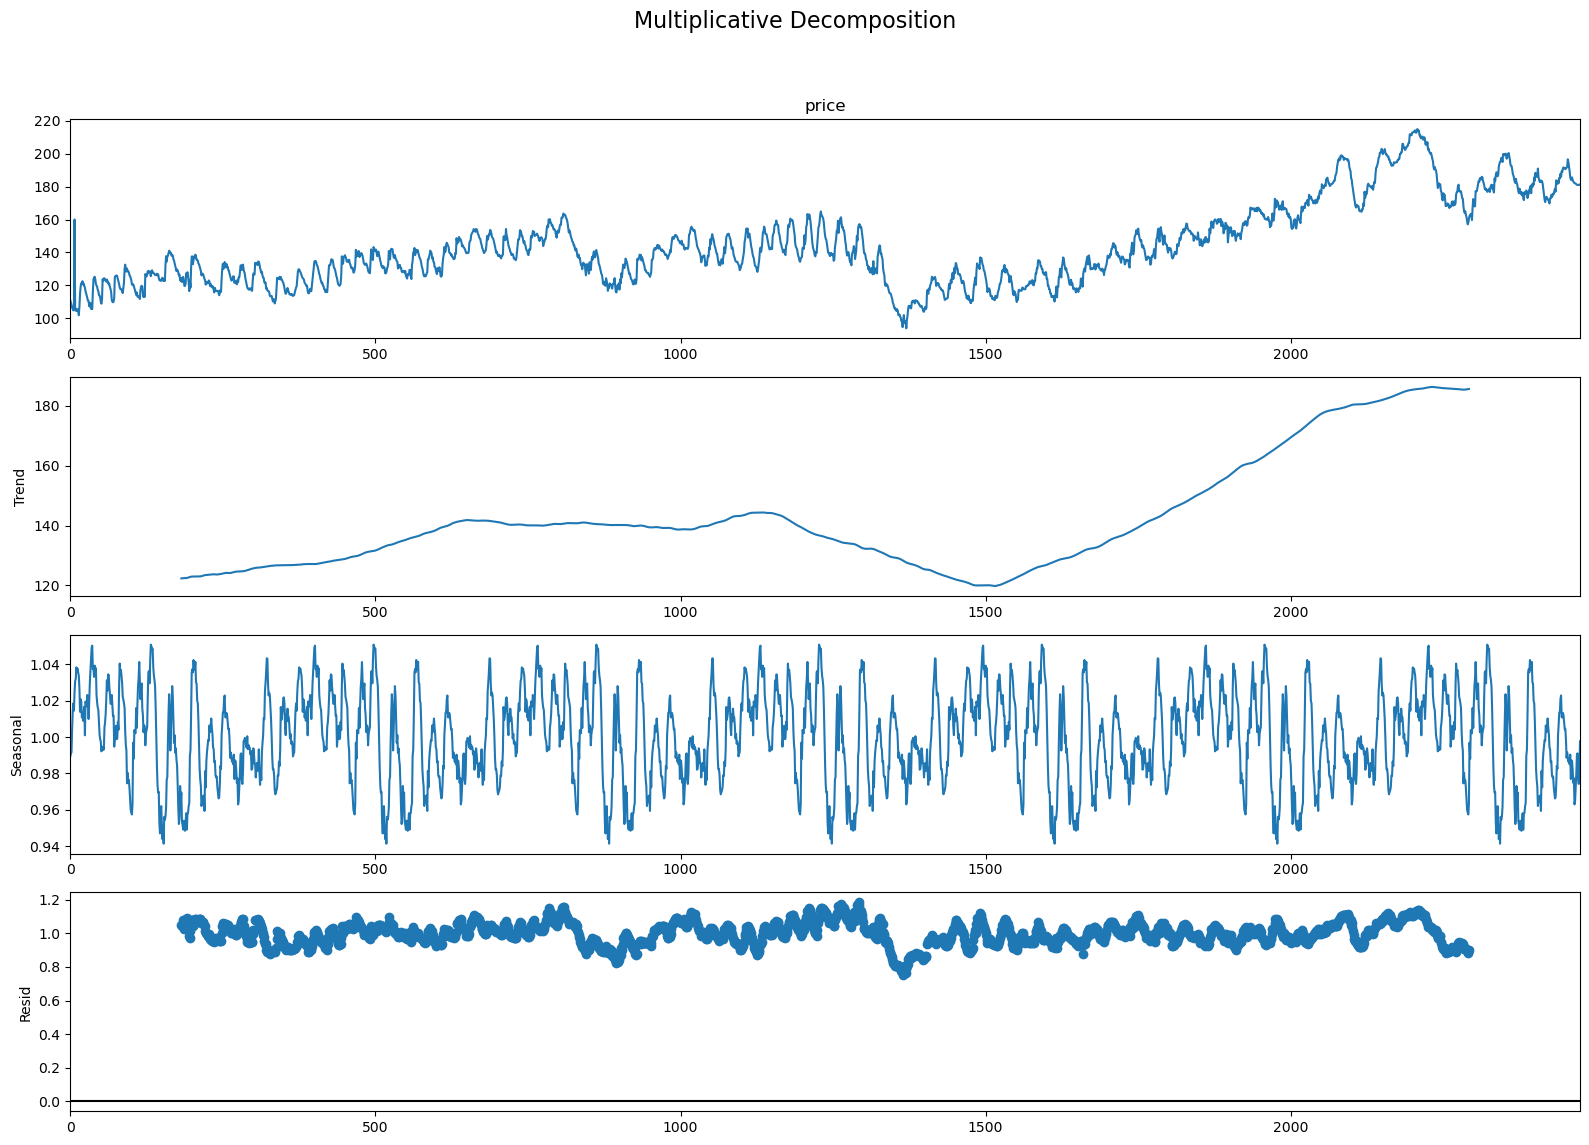

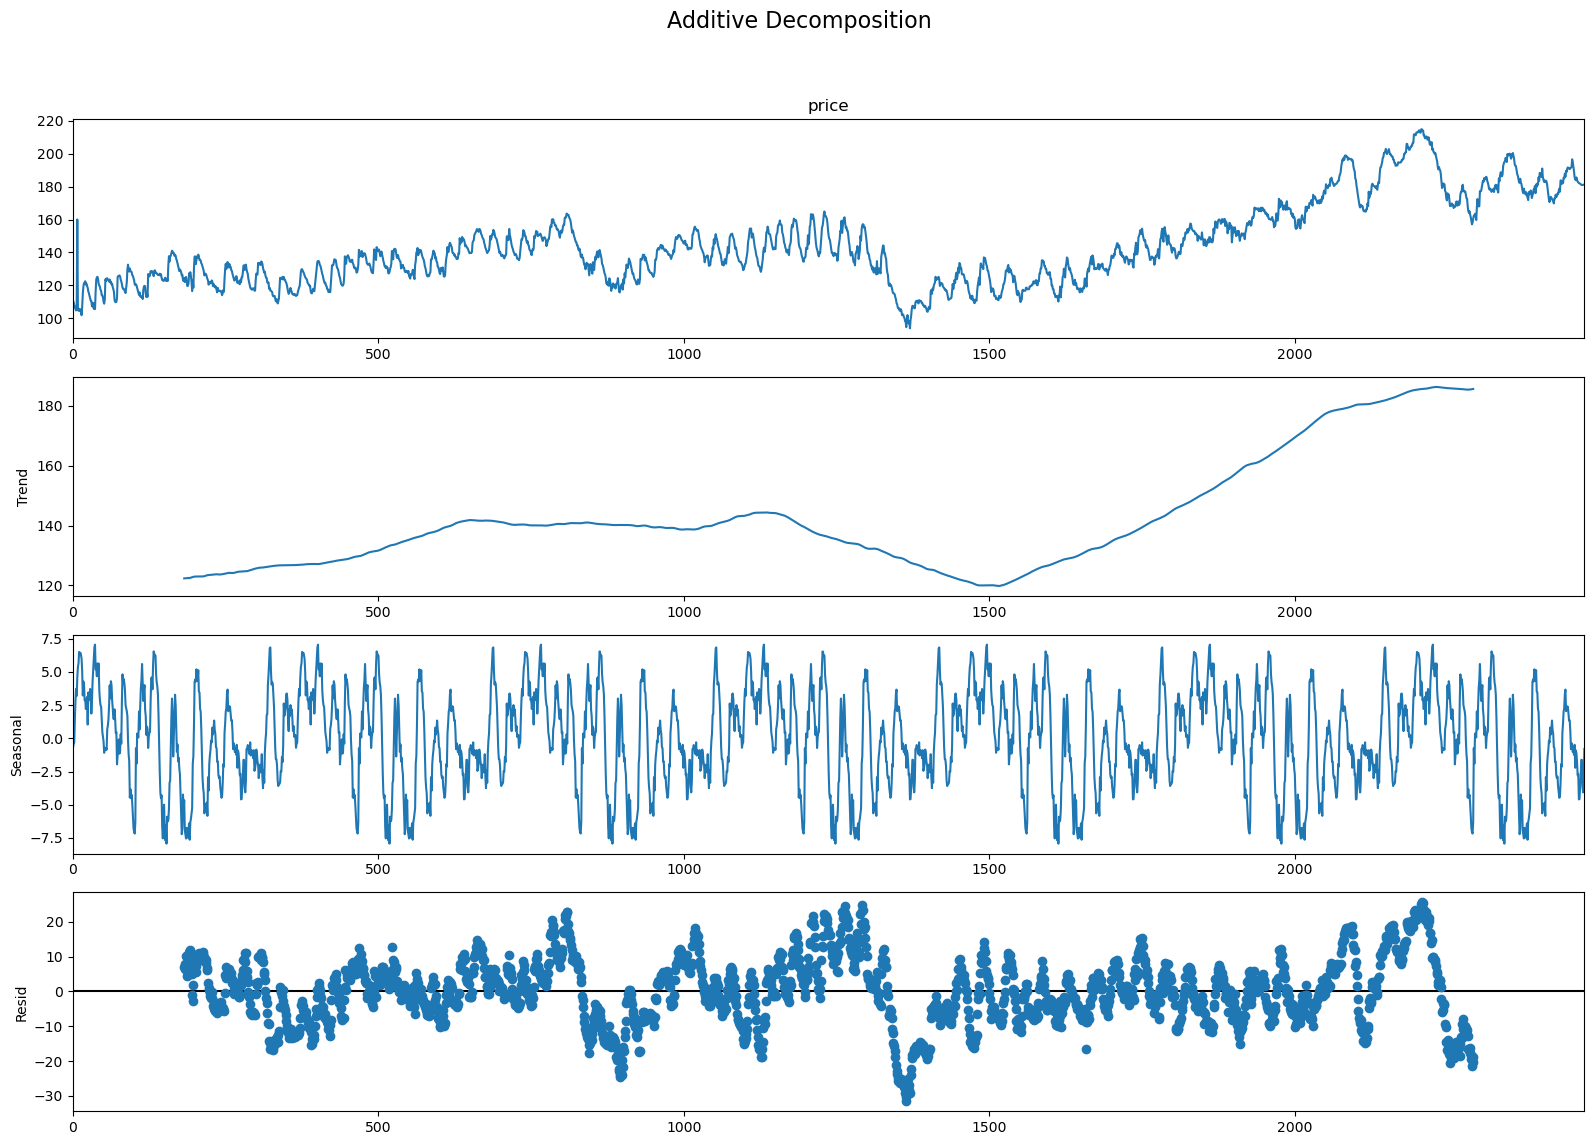

In [134]:
import matplotlib.pyplot as plt
# Multiplicative Decomposition 
multiplicative_decomposition = seasonal_decompose(df_all['price'], model='multiplicative', period=365)

# Additive Decomposition
additive_decomposition = seasonal_decompose(df_all['price'], model='additive', period=365)

# Plot
plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

#### Train/Test

In [171]:
cutoff = '2022-12-31'
start_date = '2016-09-01'
df_train = df_all[df_all['date'].between(start_date,cutoff)].reset_index(drop=True)
df_test = df_all[df_all['date']>=cutoff].reset_index(drop=True)

### 1. ARIMA

In [163]:
from statsmodels.tsa.stattools import adfuller


In [182]:
result = adfuller(df_train['price'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.680255
p-value: 0.441313


Since P-value is greater than the significance level, let’s difference the series and see how the autocorrelation plot looks like.

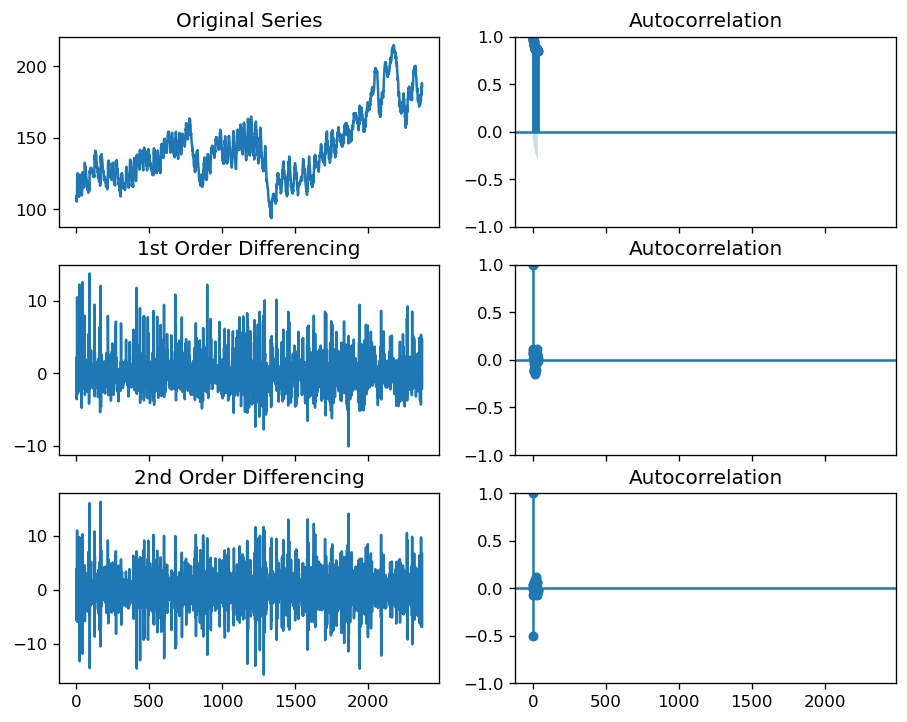

In [174]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df_train['price']); axes[0, 0].set_title('Original Series')
plot_acf(df_train['price'], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df_train['price'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_train['price'].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df_train['price'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df_train['price'].diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [179]:
from pmdarima.arima.utils import ndiffs
## Adf Test
print(ndiffs(df_train['price'], test='adf')) 

# KPSS test
print(ndiffs(df_train['price'], test='kpss')) 

# PP test:
print(ndiffs(df_train['price'], test='pp')) 

1
1
0


**Auto Arima**

In [185]:
import pmdarima as pm

model = pm.auto_arima(
    df_train['price'],
    start_p=1,
    start_q=1,
    max_p=3,
    max_q=3,
    m=365,
    d=1
)

KeyboardInterrupt: 

### 2. Darts

In [304]:
import darts
from darts import TimeSeries
from darts.models import NaiveSeasonal, NaiveDrift, ExponentialSmoothing, TBATS, AutoARIMA, Theta
from darts.utils.statistics import plot_residuals_analysis
from darts.metrics import mape


In [223]:
cutoff = '2023-01-01'
start_date = '2016-08-31'

train, test = ts_all.split_before(pd.Timestamp(cutoff))

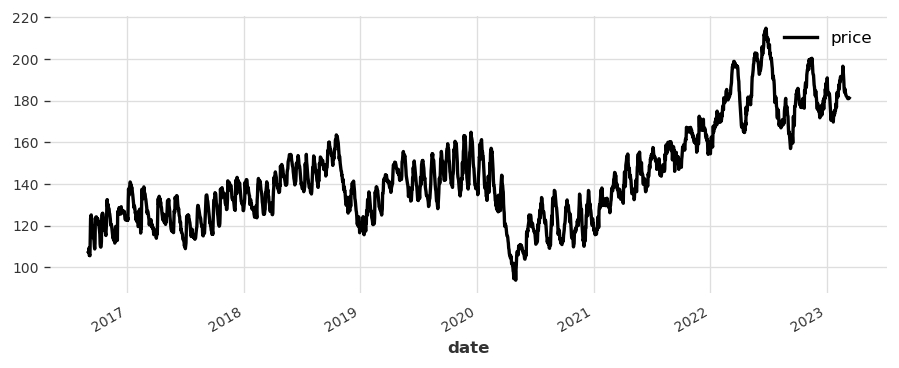

In [224]:
ts_all = TimeSeries.from_dataframe(df_all.reset_index(drop=True), time_col='date').drop_before(pd.Timestamp(start_date))
ts_all.plot()

### 2.1 Naive Models

In [276]:
MODELS = {}

In [298]:
def quick_plot(label):
    ts_all.drop_before(pd.Timestamp('2022-01-01')).plot(label='acutal')
    MODELS[label][1].plot(label=label)

def get_results():
    return pd.DataFrame([{'model': m, 'mape': mape(test, MODELS[m][1])} for m in MODELS]).sort_values('mape').reset_index(drop=True)

def quick_train_and_fc(model, label):
    model.fit(train)
    forecast = model.predict(len(test))
    MODELS[label] = [model, forecast]

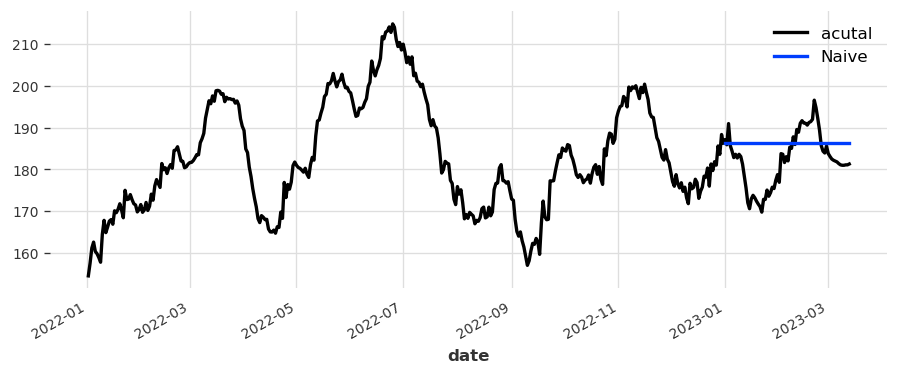

In [277]:
naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast = naive_model.predict(len(test))

MODELS['Naive'] = [naive_model, naive_forecast]

quick_plot('Naive')

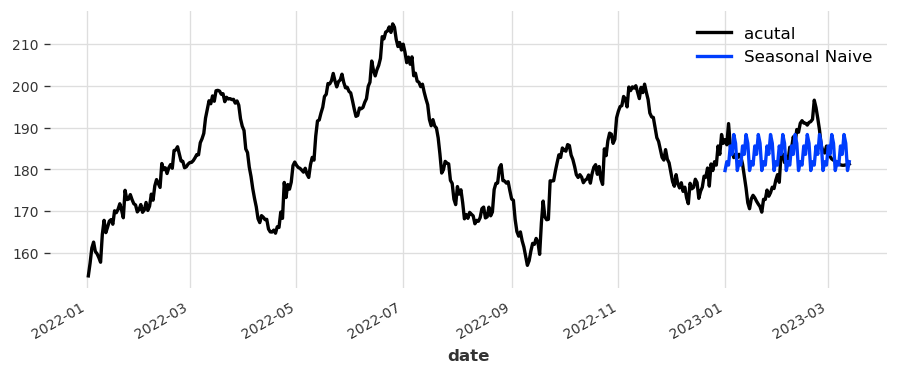

In [278]:
seasonal_model = NaiveSeasonal(K=7)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(len(test))

MODELS['Seasonal Naive'] = [seasonal_model, seasonal_forecast]

quick_plot('Seasonal Naive')

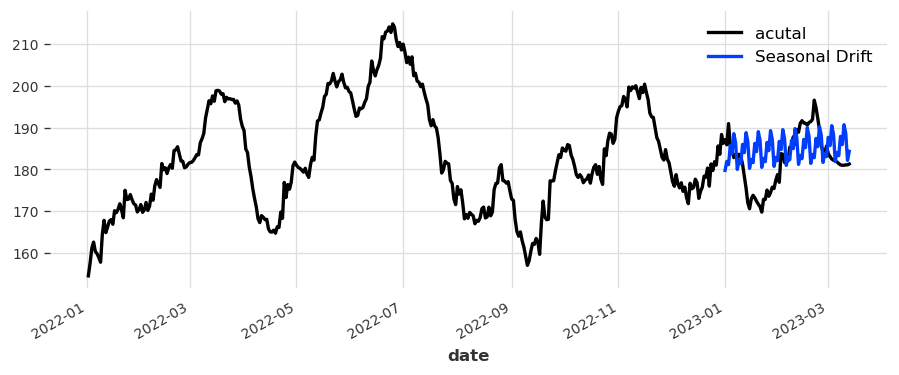

In [279]:
drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(len(test))

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

MODELS['Seasonal Drift'] = [None, combined_forecast]

quick_plot('Seasonal Drift')


### 2.2 Error Metrics

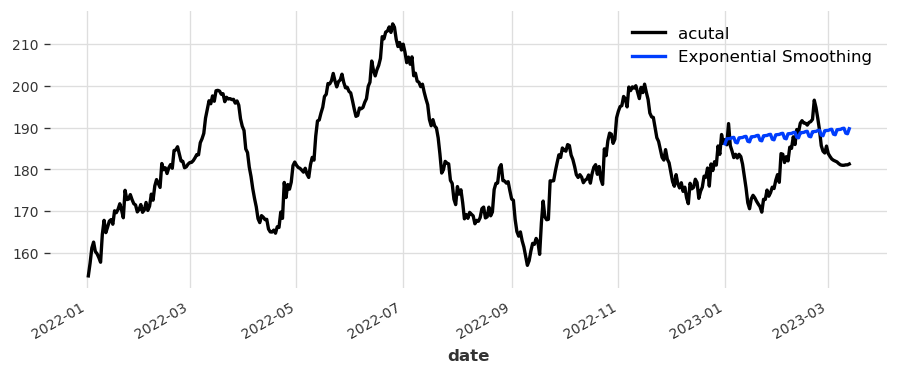

In [286]:
quick_train_and_fc(ExponentialSmoothing(), 'Exponential Smoothing')
quick_plot('Exponential Smoothing')

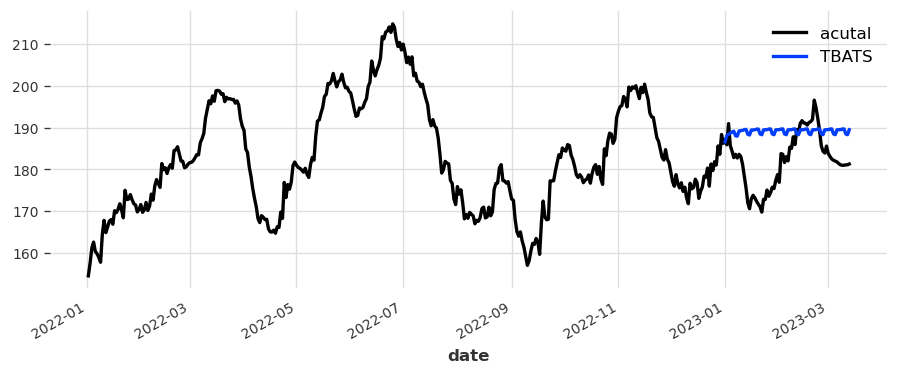

In [292]:
quick_train_and_fc(TBATS(), 'TBATS')
quick_plot('TBATS')

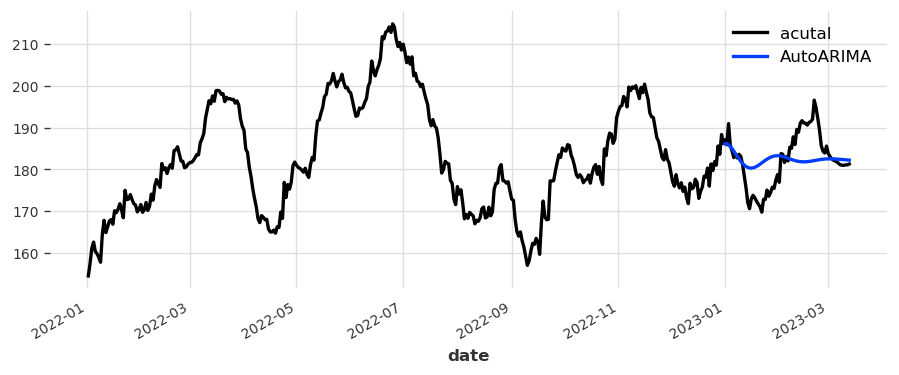

In [293]:
quick_train_and_fc(AutoARIMA(), 'AutoARIMA')
quick_plot('AutoARIMA')

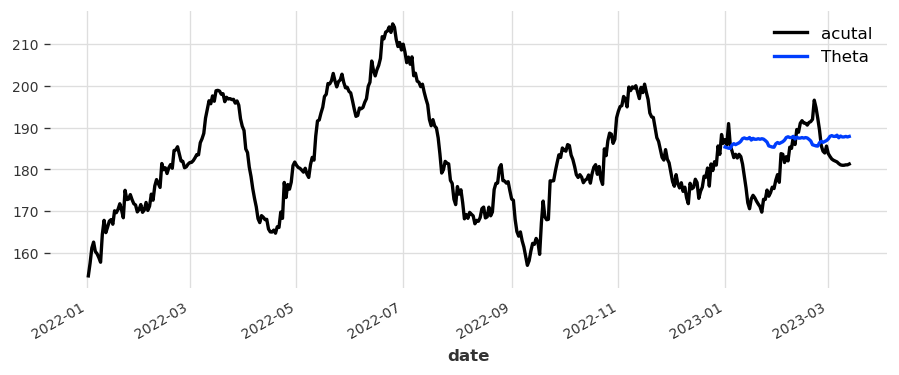

In [294]:
quick_train_and_fc(Theta(), 'Theta')
quick_plot('Theta')

In [299]:
get_results()

,model,mape
0,AutoARIMA,2.649667
1,Seasonal Naive,3.289629
2,Seasonal Drift,3.410940
3,Naive,3.452930
4,Theta,3.719535
5,Exponential Smoothing,4.015763
6,TBATS,4.359844


In [305]:
plot_residuals_analysis(MODELS['AutoARIMA'][0].residuals(ts_all))

KeyboardInterrupt: 

In [302]:
dir(MODELS['AutoARIMA'][0])

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_assert_univariate',
 '_build_forecast_series',
 '_default_save_path',
 '_expect_future_covariates',
 '_expect_past_covariates',
 '_extract_model_creation_params',
 '_fit',
 '_fit_called',
 '_fit_wrapper',
 '_generate_new_dates',
 '_get_historical_forecastable_time_index',
 '_get_last_prediction_time',
 '_historical_forecasts_sanity_checks',
 '_is_probabilistic',
 '_model_encoder_settings',
 '_model_params',
 '_predict',
 '_predict_sample_time_index_length',
 '_predict_wrapper',
 '_sample_params',
 '_supports_non_retrainable_historical_forecasts',
 '_supports_range_inde

In [378]:
h_obs = 28
t_obs = 22

f_left = 100 - h_obs - t_obs

ress = []

for _ in range(100000):
    heads = h_obs
    for _ in range(f_left):
        heads += np.random.random() < 0.5


    eq = (heads - (100-heads))**3

    ress.append(eq)

np.std(ress)

2366.6905835662205

In [375]:
np.mean(ress)

-4.7724

In [ ]:
sds = [2340]

3818.380650198212

In [315]:
f_left

100

In [316]:
heads

55

In [317]:
eq

1000